In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


import celerite2
from celerite2 import terms

from scipy.optimize import minimize,curve_fit

import os
CWD = "/".join(os.getcwd().split("/")[:-2])
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")

from funcs.helper import read_custom_aperture_lc, fetch_lightcurve
from funcs.multiperiod import show_flare, find_period


def get_period_get_amplitude(target, plot=False, save=False, plotmini=False):
    """Fit a sinusoidal modulation and
    subtract it from the flux.

    Parameters:
    -----------
    target : Series
        Description of the target.
    plot : bool
        If True, will plot the periodogram
    save : bool
        If True, will save periodogram plot to file.

    Return:
    -------
    time, subtracted flux, model, period:
    array, array, array, astropy.Quantity
    """
    def cosine(x, a, b, c, d, e):
        """cosine with a linear trend"""
        return a * np.cos(b * x + c) + d * x + e

    # Fetch light curve
#     if target.origin=="custom":
    flck = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")
#     else: 
#         flck = flc

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False, custom=target.origin, flc=flck)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
#     if cut is not None:
#         cond = cond & (flck.time > cut[0]) & (flck.time < cut[1])
    p, p_cov = curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])
    subtracted_flux = np.nanmedian(flck.flux) + flck.flux - model
    print(target.ID, p)
    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    return period, rel_amplitude, p

In [3]:
# select a target
target = lcs.iloc[2]

In [118]:
# get TESS LC here

flc = fetch_lightcurve(target)
select = np.where((flc.time > target.view_start-1.5) & (flc.time < target.view_stop+.2))
flc = flc[select]

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [119]:
true_t = flc.time
true_y = flc.flux

(1329.5, 1335.5)

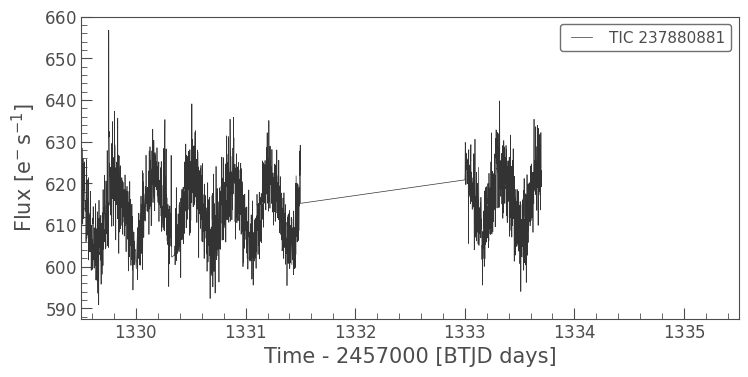

In [122]:
flcm.plot()
plt.xlim(target.view_start-1.5, target.view_stop+2)

In [123]:
# mask flare here

# 237
# 1333, 1331.5
mask = np.where((flc.time > 1333) | (flc.time < 1331.5))
flcm = flc[mask]


In [124]:
# maybe mask all other flares too?

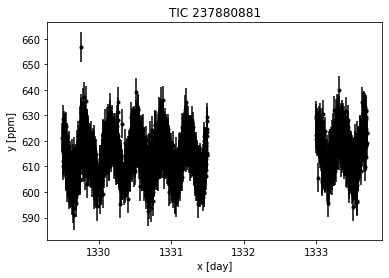

In [125]:
t = flcm.time
y = flcm.flux
yerr = flcm.flux_err


# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
_ = plt.title(f"TIC {target.ID}")

In [126]:
# add periodogram here as input for term 1

period, rel_amplitude, p = get_period_get_amplitude(target)

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.440140530163145 h
237880881 [-7.75192301e+00  1.78681079e+01 -1.55852265e+00  2.18150339e-02
  5.89294737e+02]


In [127]:
P= period.to("d").value
p, P

(array([-7.75192301e+00,  1.78681079e+01, -1.55852265e+00,  2.18150339e-02,
         5.89294737e+02]),
 0.351672522090131)

In [128]:
flcm.flux.shape

(1876,)

In [133]:
# Quasi-periodic term
term1 = terms.SHOTerm(sigma=5.5, rho=P, tau=100.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=5.5, rho=100.06, Q=.5)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(t, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -12227.332247978313


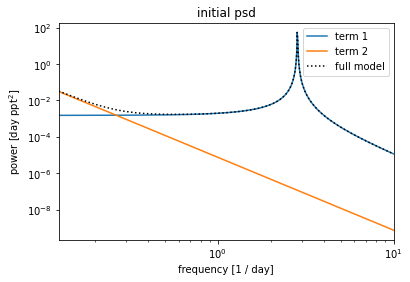

In [134]:
freq = np.linspace(1.0 / 8, 1.0 / 0.1, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label="term {0}".format(n + 1))
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)

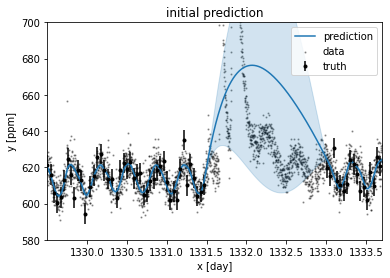

In [138]:
def plot_prediction(gp):
    plt.scatter(true_t, true_y, c="k", s=1.5, alpha=0.3, label="data")
    plt.errorbar(t[::30], y[::30], yerr=yerr[::30], fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="prediction")
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(flcm.time[0], flcm.time[-1])
    plt.ylim(580,700)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)

In [136]:


def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(t, diag=yerr ** 2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(y)


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

      fun: 5951.660006686991
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00527507,  0.01964509, -0.01036824,  0.00381988,  0.02282832,
        0.00227374,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 208
      nit: 23
   status: 0
  success: True
        x: array([ 0.01458874, -0.01649188,  0.02120455,  2.29809208,  5.9947528 ,
        2.35460831, -4.60517019])

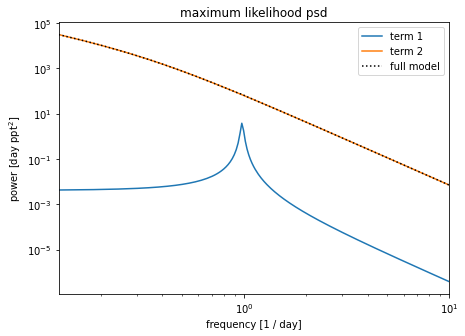

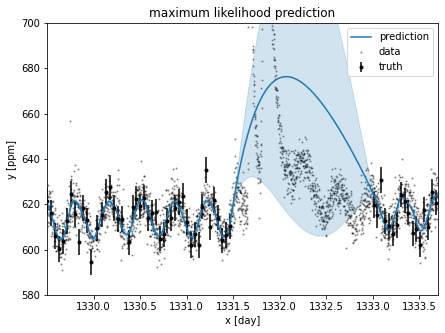

In [137]:
plt.figure(figsize=(7,5))
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

plt.figure(figsize=(7,5))
plt.title("maximum likelihood prediction")
plot_prediction(opt_gp)

In [75]:
import emcee

prior_sigma = 2.0


def log_prob(params, gp):
    gp = set_params(params, gp)
    return (
        gp.log_likelihood(y) - 0.5 * np.sum((params / prior_sigma) ** 2),
        gp.kernel.get_psd(omega),
    )



coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob, args=(gp,)
)
state = sampler.run_mcmc(coords, 200, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 500, progress=True)

100%|██████████| 500/500 [00:08<00:00, 55.85it/s]


In [76]:
chain = sampler.get_chain(discard=10, flat=True)

for sample in chain[np.random.randint(len(chain), size=50)]:
    gp = set_params(sample, gp)
    conditional = gp.condition(y, true_t)
    plt.plot(true_t, conditional.sample(), color="C0", alpha=0.1)

plt.title("posterior prediction")
plot_prediction(None)

AttributeError: 'GaussianProcess' object has no attribute 'condition'